# Intro to NEMS

This notebook covers some basic overview of how NEMS works, form loading data to creating a `modelspec` of a model and evaluating it. 

In [1]:
import pickle
from pathlib import Path

import nems0.analysis.api
import nems0.initializers
import nems0.recording as recording
import nems0.uri
from nems0.fitters.api import scipy_minimize
from nems0.signal import RasterizedSignal

[nems.configs.defaults INFO] Saving log messages to /tmp/nems\NEMS 2020-05-28 133134.log


## Configuration

Raw data is usually saved in the `recording` directory in NEMS. You can specify a custom save data location in your NEMS config file.

In [2]:
# get the data and results paths
signals_dir = Path(nems.NEMS_PATH) / 'recordings'

In [3]:
# download some demo data
recording.get_demo_recordings(signals_dir)
datafile = signals_dir / 'TAR010c-18-1.pkl'

## Load and Format Recording Data

In [4]:
with open(datafile, 'rb') as f:
    cellid, rec_name, fs, X, Y, epochs = pickle.load(f)

A `recording` object contains a set of `signal` objects, along with some associated metadata. `signal` objects can be of various types
depending on your use case. `signal` data is stored as `channel x time` arrays.

In [5]:
# create NEMS formatted signal objects from the raw data
resp = RasterizedSignal(fs, Y, 'resp', rec_name, epochs=epochs, chans=[cellid])
stim = RasterizedSignal(fs, X, 'stim', rec_name, epochs=epochs)

In [6]:
# create the recording object from the signals
signals = {'resp': resp, 'stim': stim}
rec = recording.Recording(signals)

To validate the model after training, the data is split into `est` and `val` datasets.

In [7]:
est, val = rec.split_using_epoch_occurrence_counts(epoch_regex="^STIM_")

## Initialize the Modelspec

Modelspec names are shorthand keyword strings. The below one defines a model, which constrains the spectral tuning to be gaussian and adds a static output non linearity.

In [8]:
modelspec_name = 'wc.18x2.g-fir.2x15-lvl.1-dexp.1'

In [9]:
# record some meta data for display and saving
meta = {'cellid': cellid,
        'batch': 271,
        'modelname': modelspec_name,
        'recording': cellid
       }

modelspec = nems.initializers.from_keywords(modelspec_name, meta=meta)

[nems.initializers INFO] kw: wc.18x2.g
[nems.initializers INFO] kw: fir.2x15
[nems.initializers INFO] kw: lvl.1
[nems.initializers INFO] kw: dexp.1
[nems.initializers INFO] Setting modelspec[0] input to stim


## Run an Analysis

The model is fit to the data using a basic gradient approach.

In [10]:
modelspec = nems.analysis.api.fit_basic(est, modelspec, fitter=scipy_minimize)

[nems.analysis.fit_basic INFO] Data len pre-mask: 206974
[nems.analysis.fit_basic INFO] Data len post-mask: 148500
[nems.modelspec INFO] Freezing fast rec at start=0
[nems.fitters.fitter INFO] options {'ftol': 1e-07, 'maxiter': 1000, 'maxfun': 10000}
[nems.fitters.fitter INFO] Start sigma: [ 0.4167  0.5833  0.3192  0.3192  0.      0.1    -0.05    0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.1    -0.05    0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      1.
  0.      1.      0.    ]
[nems.analysis.cost_functions INFO] Eval #100. E=1.103888
[nems.analysis.cost_functions INFO] Eval #200. E=1.051702
[nems.analysis.cost_functions INFO] Eval #300. E=1.000810
[nems.analysis.cost_functions INFO] Eval #400. E=0.998919
[nems.analysis.cost_functions INFO] Eval #500. E=0.985356
[nems.analysis.cost_functions INFO] Eval #600. E=0.979484
[nems.analysis.cost_functions INFO] Eval #700. E=0.973421
[

## Generate Summary Statistics

In [11]:
# generate predictions
est, val = nems.analysis.api.generate_prediction(est, val, modelspec)

In [12]:
# evaluate prediction accuracy
modelspec = nems.analysis.api.standard_correlation(est, val, modelspec)

In [13]:
# results
print("Performance: r_fit={0:.3f} r_test={1:.3f}".format(
        modelspec.meta['r_fit'][0][0],
        modelspec.meta['r_test'][0][0]))

Performance: r_fit=0.346 r_test=0.353


## Genenrate Plots

[nems.modelspec INFO] Quickplot: no epoch specified, falling back to "TRIAL"
[nems.modelspec WARNING] Quickplot: no valid epochs matching TRIAL. Will not subset data.
[nems.modelspec INFO] plotting row 1/6
[nems.modelspec INFO] plotting row 2/6
[nems.modelspec INFO] plotting row 3/6
[nems.modelspec INFO] plotting row 4/6
[nems.modelspec INFO] plotting row 5/6


bin range: 0-500


[nems.modelspec INFO] plotting row 6/6
[nems.modelspec INFO] Quickplot: generated fig with title "Cell: TAR010c-18-1, Batch: 271, None #0 wc.18x2.g-fir.2x15-lvl.1-dexp.1"


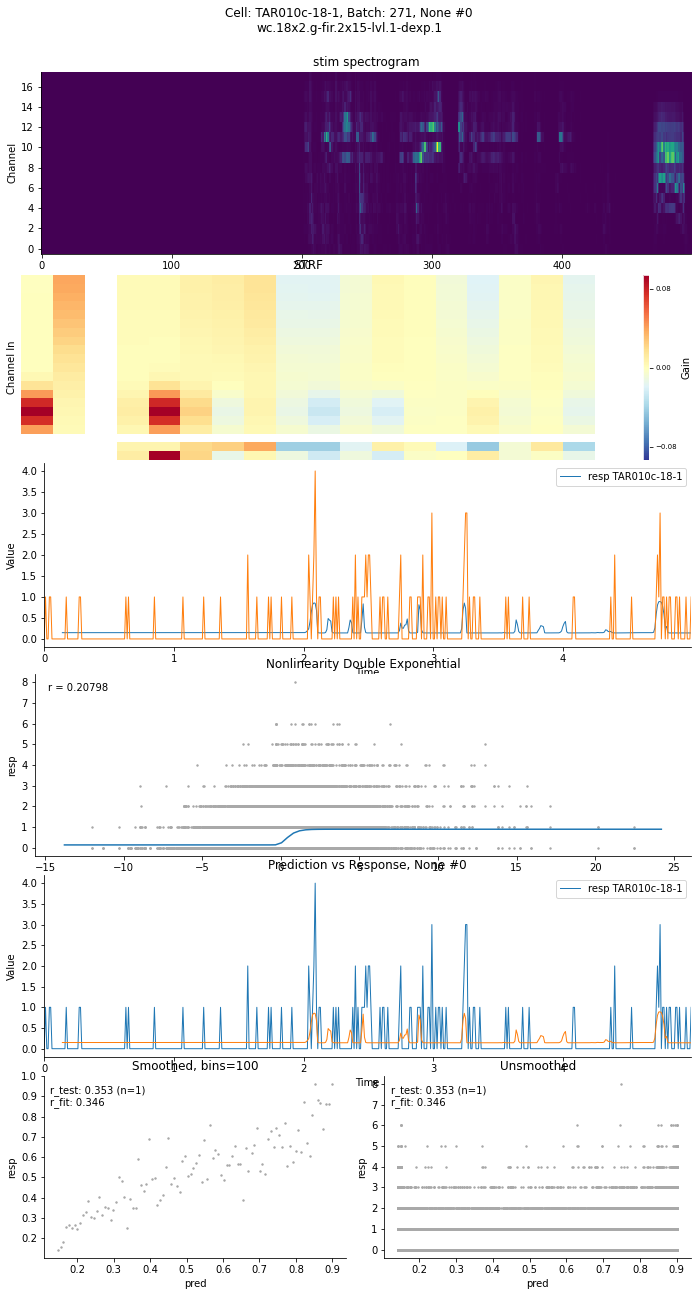

In [14]:
fig = modelspec.quickplot(rec=est)